# 3.0 - Baseline Model

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

import pandas as pd

from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()

In [2]:
df = pd.read_csv("../data/processed/kddcup_data_processed.csv")
X = df.drop(columns=["attack_type"])
y = df["attack_type"]

In [3]:
df.shape, X.shape, y.shape

((494021, 32), (494021, 31), (494021,))

In [16]:
X_scaled = scaler.fit_transform(X)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

---

In [18]:
rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [19]:
rf_clf.score(X_test, y_test)

0.999757097312889

In [20]:
import pandas as pd

pd.DataFrame({'actual': y_test, 'predicted': rf_clf.predict(X_test)})

,actual,predicted
424218,dos,dos
357223,dos,dos
141206,probe,probe
28798,normal,normal
187138,dos,dos
...,...,...
405716,dos,dos
13599,normal,normal
295273,dos,dos
486417,normal,normal


In [21]:
print(classification_report(y_test, rf_clf.predict(X_test)))

              precision    recall  f1-score   support

         dos       1.00      1.00      1.00     78292
      normal       1.00      1.00      1.00     19456
       probe       1.00      1.00      1.00       822
         r2l       1.00      0.96      0.98       225
         u2r       0.75      0.60      0.67        10

    accuracy                           1.00     98805
   macro avg       0.95      0.91      0.93     98805
weighted avg       1.00      1.00      1.00     98805



In [22]:
f1_score(y_test, rf_clf.predict(X_test), average='weighted')

0.9997526180528381

In [23]:
from sklearn.metrics import confusion_matrix

y_pred = rf_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)


[[78288     4     0     0     0]
 [    1 19452     1     1     1]
 [    0     2   820     0     0]
 [    1     8     0   215     1]
 [    0     4     0     0     6]]


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def plot_cm(y_true, y_pred, figsize=(10,10)):   
        
        cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
        cm_sum = np.sum(cm, axis=1, keepdims=True)
        cm_perc = cm / cm_sum.astype(float) * 100
        annot = np.empty_like(cm).astype(str)
        nrows, ncols = cm.shape
        for i in range(nrows):
            for j in range(ncols):
                c = cm[i, j]
                p = cm_perc[i, j]
                if i == j:
                    s = cm_sum[i]
                    annot[i, j] = '%.3f%%\n%d/%d' % (p, c, s)
                elif c == 0:
                    annot[i, j] = ''
                else:
                    annot[i, j] = '%.3f%%\n%d' % (p, c)
        cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
        cm.index.name = 'Actual'
        cm.columns.name = 'Predicted'
        fig, ax = plt.subplots(figsize=figsize)
        sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

/var/folders/15/wc5q4q7x74s558bh7r8mp75c0000gn/T/ipykernel_25160/4082643656.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.3f%%\n%d/%d' % (p, c, s)


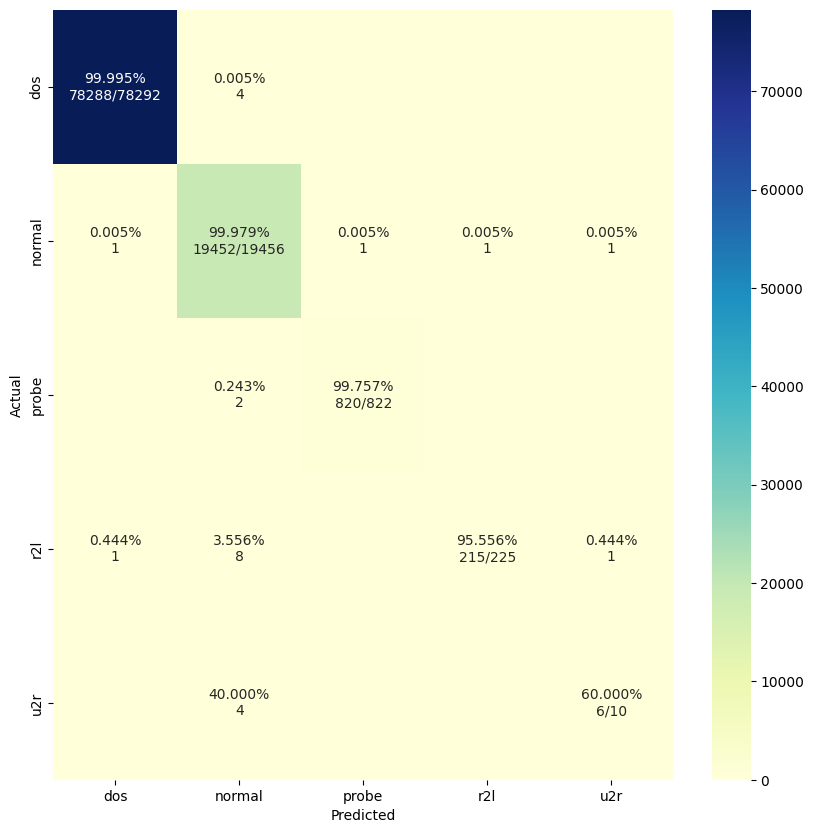

In [25]:
plot_cm(y_test, y_pred)

---

In [29]:
import optuna
from functools import partial

def objective(trial: optuna.Trial, X_train, y_train, X_test, y_test, clf_name="RandomForest") -> float:
    
    if clf_name == "RandomForest":
        rf_kwargs = {
            "n_estimators": trial.suggest_int("n_estimators", 80, 120),
            "max_depth": trial.suggest_int("max_depth", 5, 20),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 5, 15),
            "bootstrap": True,
            "n_jobs": -1
        }
        clf = RandomForestClassifier(**rf_kwargs)
        
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # score = accuracy_score(y_test, y_pred)
    score = f1_score(y_test, y_pred, average="weighted")

    return score

def fine_tune_algo(X_train, y_train, X_test, y_test, clf_name="RandomForest", n_trials=30):
    objective_partial = partial(objective, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, clf_name=clf_name)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective_partial, n_trials=n_trials, n_jobs=-1, show_progress_bar=True)

    best_params = study.best_params
    best_score = study.best_value

    print("===================================================")
    print(f"Best score for {clf_name} : {best_score}")
    print(f"Best params for {clf_name} : {best_params}\n")
    print("===================================================")

    return best_score, best_params
    

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42, )

best_scores, best_params = [], []
for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    best_score_rf, best_params_rf = fine_tune_algo(X_train, y_train, X_test, y_test, clf_name="RandomForest")
    best_scores.append(best_score_rf)
    best_params.append(best_params_rf)

---